In [1]:
import gym
#import gym_inventory
import numpy as np
from collections import namedtuple
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
from gym import spaces
from gym import utils
from gym.utils import seeding

import logging
logger = logging.getLogger(__name__)


class InventoryEnv(gym.Env, utils.EzPickle):
    """Inventory control with lost sales environment
    TO BE EDITED
    This environment corresponds to the version of the inventory control
    with lost sales problem described in Example 1.1 in Algorithms for
    Reinforcement Learning by Csaba Szepesvari (2010).
    https://sites.ualberta.ca/~szepesva/RLBook.html
    """

    def __init__(self, n=100, k=50, c=10, h=3, p=30, lam=8):
        self.n = n
        self.action_space = spaces.Discrete(n)
        self.observation_space = spaces.Discrete(n)
        self.max = n
        self.state = n
        self.k = k
        self.c = c
        self.h = h
        self.p = p
        self.lam = lam
        #self.demands

        # Set seed
        self._seed()

        # Start the first round
        self._reset()

    def demand(self):
        return np.random.poisson(self.lam)

    def transition(self, x, a, d):
        m = self.max
        return max(min(x + a, m) - d, 0)

    def reward(self, x, a, y):
        k = self.k
        m = self.max
        c = self.c
        h = self.h
        p = self.p
        r = -k * (a > 0) - c * max(min(x + a, m) - x, 0) - h * x + p * max(min(x + a, m) - y, 0)
        return r

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        assert self.action_space.contains(action)
        obs = self.state
        demand = self.demand()
        self.demands = demand
        obs2 = self.transition(obs, action, demand)
        self.state = obs2
        reward = self.reward(obs, action, obs2)
        done = 0
        return obs2, reward, done,{}

    def _reset(self):
        self.state = 100
        return self.state

In [3]:
class QLearningAgent:
    def __init__(self, observation_space_size, action_space_size, learning_rate=0.05,
                 discount_factor=0.6, exploration_rate=0.1):
        self.Q = np.zeros((observation_space_size+1, action_space_size)) # Initialize Q-table with zeros
        self.learning_rate = learning_rate # Learning rate (alpha)
        self.discount_factor = discount_factor # Discount factor (gamma)
        self.exploration_rate = exploration_rate # Exploration rate (epsilon)

    def choose_action(self, state):
        if np.random.uniform() < self.exploration_rate: # Explore
            action = np.random.randint(self.Q.shape[1])
        else: # Exploit
            action = np.argmax(self.Q[state, :])
        return action

    def update_q_table(self, state, action, reward, next_state):
        td_error = reward + self.discount_factor * (np.max(self.Q[next_state, :]) - self.Q[state, action])
        self.Q[state, action] += self.learning_rate * td_error
        

In [4]:
class SarsaAgent:
    def __init__(self, observation_space_size, action_space_size, num_actions=100,learning_rate=0.05,
                 discount_factor=0.6, exploration_rate=0.1):
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.Q = np.zeros((observation_space_size + 1, action_space_size))
    
    def choose_action(self, state):
        # Epsilon-greedy exploration
        if np.random.uniform() < self.exploration_rate:
            return np.random.randint(0, self.num_actions - 1)
        else:
            return np.argmax(self.Q[state])
    
    def update_q_table(self, state, action, reward, next_state, next_action, done):
        if not done:
            sarsa_target = reward + self.discount_factor * (self.Q[next_state][next_action])
            sarsa_delta = sarsa_target - self.Q[state][action]
            self.Q[state][action] += self.learning_rate * sarsa_delta
            

In [5]:
def run_inventory_management_Q():
    # Create the inventory management environment
    env = InventoryEnv()
    
    # Create the Q-learning agent
    agent = QLearningAgent(env.observation_space.n, env.action_space.n)
    step_rewards=np.zeros(5000)
    step_demands=np.zeros(5000)
    Total_reward = 0
    

    # Train the agent
    for episode in range(5000):
        state = env.reset()
        if episode%1000 == 0:
            print('-------', episode,'-------')
        done = False
        for step in range(50):
            action = agent.choose_action(state)
            next_state, reward, done,_ = env.step(action)
            
#                     print('step ', step , ' action ', action, ' key :', key, '  value :', value)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            Total_reward+= reward
        step_rewards[episode] = Total_reward
    epi = np.arange(5000)

    
    # Test the agent
    state = env.reset()
    done = False
    total_reward = 0
    x = np.arange(100)
    y = np.zeros(100)
    step_demands=np.zeros(100)
    step_actions=np.zeros(100)
    step_state = np.zeros(100)
    for step in range(100):
        step_state[step] = state
        action = np.argmax(agent.Q[state, :])
        step_actions[step] = action
        state, reward, done,_ = env.step(action)
        step_demands[step]=env.__dict__['demands']
        y[step] = reward
        count = np.sum(y>0)
        total_reward += reward
    
    print("Total reward:", total_reward,"Demand managed:",count)

    
    fig3, ax = plt.subplots(nrows=1, ncols=1,figsize=(14, 7))
    ax.plot(x,step_actions, label='Actions')
    ax.plot(x,step_demands, label='Demands')
    ax.plot(x,step_state, label='State')
    ax.legend(loc='upper right')
    plt.xlabel("Steps")
    plt.ylabel("Metrics")
    plt.title("Action & state VS Demand for Q-Learning")
    plt.show(fig3)
    
    return epi, step_rewards, x, y


In [6]:
def run_inventory_management_S():
    # Create the inventory management environment
    env = InventoryEnv()
    
    # Create the Sarsa agent
    agent = SarsaAgent(env.observation_space.n, env.action_space.n)
    step_rewards=np.zeros(5000)
    step_demands=np.zeros(5000)
    Total_reward = 0
    

    # Train the agent
    for episode in range(5000):
        state = env.reset()
        action = agent.choose_action(state)
        if episode%1000 == 0:
            print('-------', episode,'-------')
        done = False
        for step in range(100):
            
            next_state, reward, done,_ = env.step(action)
            next_action = agent.choose_action(next_state)

                    
#                     print('step ', step , ' action ', action, ' key :', key, '  value :', value)
            agent.update_q_table(state, action, reward, next_state,next_action,done)
            state = next_state
            action = next_action
            Total_reward+= reward
        step_rewards[episode] = Total_reward
    epi = np.arange(5000)

    
    # Test the agent
    state = env.reset()
    done = False
    total_reward = 0
    my_range = 100
    x = np.arange(my_range)
    y = np.zeros(my_range)
    step_demands=np.zeros(my_range)
    step_actions=np.zeros(my_range)
    step_state = np.zeros(my_range)
    for step in range(my_range):
        step_state[step] = state
        action = np.argmax(agent.Q[state, :])
        step_actions[step] = action
        state, reward, done,_ = env.step(action)
        step_demands[step]=env.__dict__['demands']
        y[step] = reward
        count = np.sum(y>0)
        total_reward += reward
    
    print("Total reward:", total_reward,"Demand managed:",count)


    
    fig3, ax = plt.subplots(nrows=1, ncols=1,figsize=(14, 7))
    ax.plot(x,step_actions, label='Actions')
    ax.plot(x,step_demands, label='Demands')
    ax.plot(x,step_state, label='State')
    ax.legend(loc='upper right')
    plt.xlabel("Steps")
    plt.ylabel("Metrics")
    plt.title("Action & state VS Demand for Sarsa")
    plt.show(fig3)

    return epi, step_rewards, x, y


------- 0 -------
------- 1000 -------
------- 2000 -------
------- 3000 -------
------- 4000 -------
Total reward: 8080 Demand managed: 75


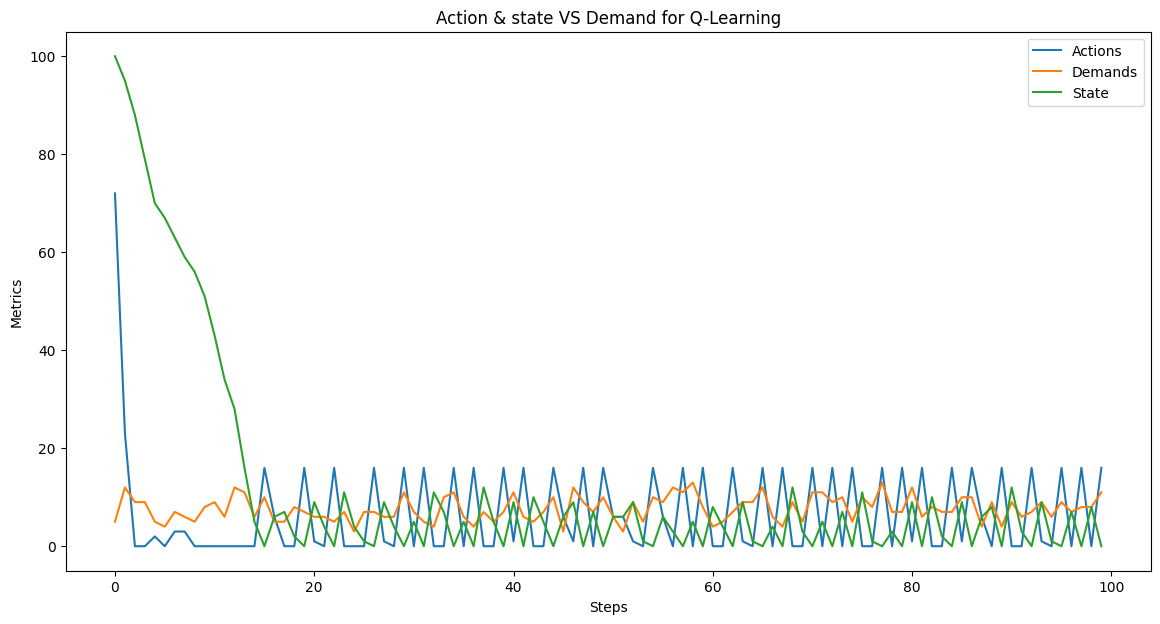

------- 0 -------
------- 1000 -------
------- 2000 -------
------- 3000 -------
------- 4000 -------
Total reward: 8827 Demand managed: 79


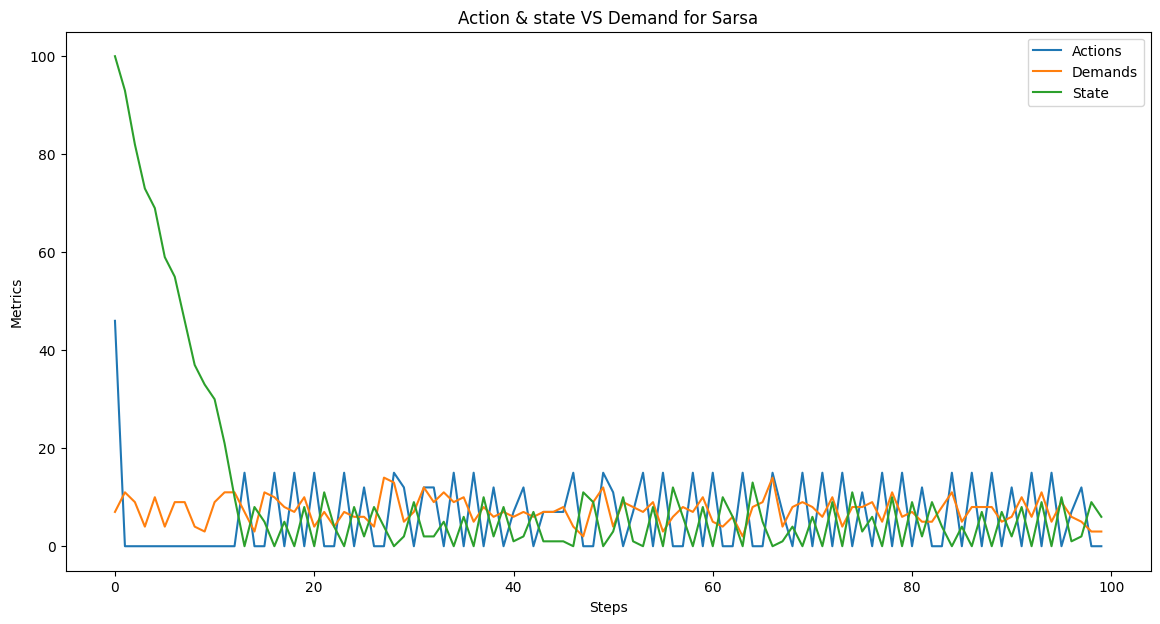

In [13]:

if __name__ == '__main__':
    ep_q, reward_q, x_q, y_q = run_inventory_management_Q()
    ep_s, reward_s, x_s, y_s = run_inventory_management_S()
    

<Figure size 800x500 with 0 Axes>

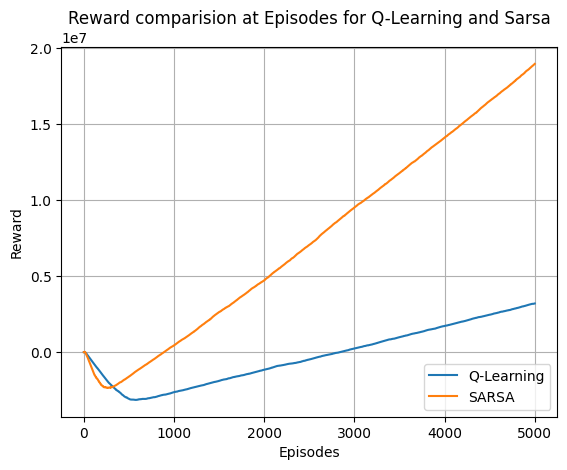

In [14]:
# Plotting Episodes and Rewards
fig1 = plt.figure(figsize=(8,5))
_, compare_episode = plt.subplots()
compare_episode.plot(ep_q, reward_q, label='Q-Learning')
compare_episode.plot(ep_s, reward_s, label='SARSA')
compare_episode.set(xlabel='Episodes', ylabel='Reward',
                    title='Reward comparision at Episodes for Q-Learning and Sarsa')
compare_episode.legend(loc='lower right')
compare_episode.grid()
plt.show(fig1)

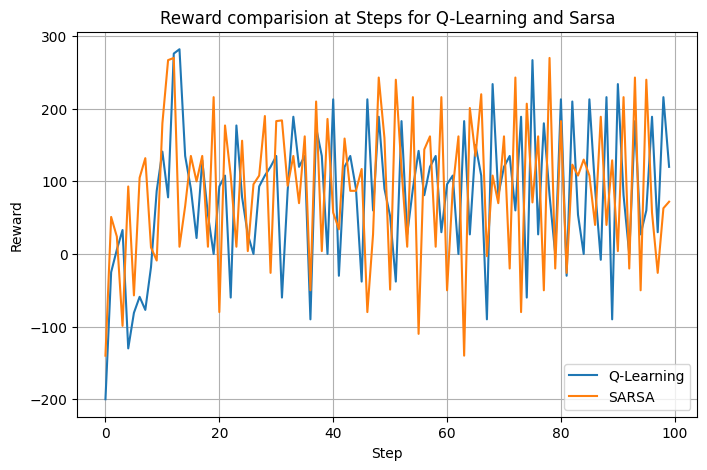

In [15]:

# Plot steps and Rewards
fig2, compare_step = plt.subplots(nrows=1, ncols=1,figsize=(8, 5))
compare_step.plot(x_q, y_q, label='Q-Learning')
compare_step.plot(x_s, y_s, label='SARSA')
compare_step.set(xlabel='Step', ylabel='Reward',
        title='Reward comparision at Steps for Q-Learning and Sarsa')
compare_step.legend(loc='lower right')
compare_step.grid()
plt.show(fig2)